In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from doe_lhs import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, nu, net):
        
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.nu = nu
        
        # deep neural networks
        self.dnn = net
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# Configurations

In [5]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 50
N_i = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('../../../datasets/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              


st = 0.30
tt = int(t.shape[0] * st)

trunk1_X = X_star[ : x.shape[0] * tt]
trunk2_X = X_star[x.shape[0] * (tt - 1) : ]

trunk1_u = u_star[ : x.shape[0] * tt]
trunk2_u = u_star[x.shape[0] * (tt - 1) : ]


# Doman bounds
lb = X_star.min(0)  # [-1.  0.]
ub = X_star.max(0)  # [1.   0.99]

first_lb = trunk1_X.min(0) # [-1.  0.] 
first_ub = trunk1_X.max(0) # [1.   0.49]

second_lb = trunk2_X.min(0) # [-1.    0.49]
second_ub = trunk2_X.max(0) # [1.   0.99]  



# --------------------- first half ---------------------

# initial conditions t = 0 for first half
xx1_1 = X_star[0:256]
uu1_1 = u_star[0:256]

# boundary conditions x = lb 
xx2_1 = np.hstack((X[0:tt,0:1], T[0:tt,0:1]))
uu2_1 = np.zeros_like(Exact[0:tt,0:1])

# boundary conditions, x = ub 
xx3_1 = np.hstack((X[:tt,-1:], T[:tt,-1:]))
uu3_1 = np.zeros_like(Exact[:tt,-1:])

# boundary points
X_u_train_1 = np.vstack([xx2_1, xx3_1]) 
u_train_1 = np.vstack([uu2_1, uu3_1])

# collocation points 
X_f_train_1 = first_lb + (first_ub-first_lb)*lhs(2, N_f)


# selecting N_u boundary points for training
idx = np.random.choice(X_u_train_1.shape[0], N_u, replace=True)
X_u_train_1 = X_u_train_1[idx, :]
u_train_1 = u_train_1[idx,:]

# selecting N_i initial points for training
idx_x_1 = np.random.choice(xx1_1.shape[0], N_i, replace=False)
X_i_train_1 = xx1_1[idx_x_1, :]
u_i_train_1 = uu1_1[idx_x_1, :]

# adding boundary and initial points
X_u_train_1 = np.vstack([X_u_train_1, X_i_train_1])
u_train_1 = np.vstack([u_train_1, u_i_train_1])


net = DNN(layers).to(device)
model = PhysicsInformedNN(X_u_train_1, u_train_1, X_f_train_1, nu, net)

In [6]:
%%time
model.train()

u_pred, f_pred = model.predict(trunk1_X)
error_u = np.linalg.norm(trunk1_u-u_pred,2)/np.linalg.norm(trunk1_u,2)
print('Error u: %e' % (error_u)) 

Iter 100, Loss: 4.77205e-02, Loss_u: 2.68716e-02, Loss_f: 2.08489e-02
Iter 200, Loss: 1.16875e-02, Loss_u: 4.60394e-03, Loss_f: 7.08351e-03
Iter 300, Loss: 2.57242e-03, Loss_u: 8.73421e-04, Loss_f: 1.69900e-03
Iter 400, Loss: 8.34752e-04, Loss_u: 1.47913e-04, Loss_f: 6.86839e-04
Iter 500, Loss: 4.01005e-04, Loss_u: 1.18342e-04, Loss_f: 2.82663e-04
Iter 600, Loss: 1.32345e-04, Loss_u: 2.60138e-05, Loss_f: 1.06331e-04
Iter 700, Loss: 8.35595e-05, Loss_u: 1.50448e-05, Loss_f: 6.85147e-05
Iter 800, Loss: 5.86129e-05, Loss_u: 8.23546e-06, Loss_f: 5.03775e-05
Iter 900, Loss: 4.22950e-05, Loss_u: 4.05800e-06, Loss_f: 3.82370e-05
Iter 1000, Loss: 3.45129e-05, Loss_u: 3.78786e-06, Loss_f: 3.07250e-05
Iter 1100, Loss: 2.58048e-05, Loss_u: 2.90391e-06, Loss_f: 2.29009e-05
Iter 1200, Loss: 2.15997e-05, Loss_u: 3.06412e-06, Loss_f: 1.85355e-05
Iter 1300, Loss: 1.79286e-05, Loss_u: 3.47334e-06, Loss_f: 1.44553e-05
Iter 1400, Loss: 1.41135e-05, Loss_u: 2.29164e-06, Loss_f: 1.18219e-05
Iter 1500, Loss

In [7]:
# --------------------- second half ---------------------


# initial conditions t = 0 for first half
xx1_2 = trunk2_X[0:256]
uu1_2 = u_pred[-256:]

# boundary conditions x = lb 
xx2_2 = np.hstack((X[tt-1:,0:1], T[tt-1:,0:1]))
uu2_2 = np.zeros_like(Exact[tt-1:,0:1])

# boundary conditions, x = ub 
xx3_2 = np.hstack((X[tt-1:,-1:], T[tt-1:,-1:]))
uu3_2 = np.zeros_like(Exact[tt-1:,-1:])

# boundary points
X_u_train_2 = np.vstack([xx2_2, xx3_2]) 
u_train_2 = np.vstack([uu2_2, uu3_2])
X_u_train_1 = np.vstack([xx2_1, xx3_1]) 
u_train_1 = np.vstack([uu2_1, uu3_1])

# collocation points 
X_f_train_1 = first_lb + (first_ub-first_lb)*lhs(2, int(N_f * st))
X_f_train_2 = second_lb + (second_ub-second_lb)*lhs(2, int(N_f - N_f * st))


# selecting N_u boundary points for training
idx = np.random.choice(X_u_train_2.shape[0], int(N_u - N_u * st), replace=False)
X_u_train_2 = X_u_train_2[idx, :]
u_train_2 = u_train_2[idx,:]

# selecting N_u boundary points for training
idx = np.random.choice(X_u_train_1.shape[0], int(N_u * st), replace=True)
X_u_train_1 = X_u_train_1[idx, :]
u_train_1 = u_train_1[idx,:]




# selecting N_i initial points for training
idx_x = np.random.choice(xx1_1.shape[0], 256, replace=False)
X_i_train_2 = xx1_2[idx_x, :]
u_i_train_2 = uu1_2[idx_x, :]


# selecting N_i initial points for training
X_i_train_1 = xx1_1[idx_x_1, :]
u_i_train_1 = uu1_1[idx_x_1, :]


# adding boundary and initial points
X_u_train_1 = np.vstack([X_u_train_1, X_u_train_2,X_i_train_1, X_i_train_2])
u_train_1 = np.vstack([u_train_1,u_train_2 ,u_i_train_1, u_i_train_2])


print(X_u_train_1.shape)
print(u_train_1.shape)


X_f_train = np.vstack([X_f_train_1,
                       X_f_train_2])

print(X_f_train.shape)

model = PhysicsInformedNN(X_u_train_1,
                          u_train_1,
                          X_f_train,
                          nu, 
                          net)


# # --------------------- second half ---------------------


# # initial conditions t = 0.49
# xx1_2 = trunk2_X[0:256]

# # boundary conditions x = lb
# xx2_2 = np.hstack((X[tt-1:,0:1], T[tt-1:,0:1]))
# uu2_2 = np.zeros_like(Exact[tt-1:,0:1])


# # boundary conditions, x = ub
# xx3_2 = np.hstack((X[tt-1:,-1:], T[tt-1:,-1:]))
# uu3_2 = np.zeros_like(Exact[tt-1:,-1:])

# # boundary points
# X_u_train_2 = np.vstack([xx2_2, xx3_2]) 
# u_train_2 = np.vstack([uu2_2, uu3_2])

# # collocation points 

# X_f_train_2 = second_lb + (second_ub-second_lb)*lhs(2, N_f) 

# # selecting N_u boundary points for training
# idx = np.random.choice(X_u_train_2.shape[0], N_u, replace=False)
# X_u_train_2 = X_u_train_2[idx, :]
# u_train_2 = u_train_2[idx,:]

# # selecting N_i initial points for training
# idx_x = np.random.choice(xx1_1.shape[0], 256, replace=False)
# X_i_train_2 = xx1_2[idx_x, :]
# # u_i_train_2 = uu1_2[idx_x, :]

# # adding boundary and initial points
# X_u_train_2 = np.vstack([X_u_train_2, X_i_train_2])
# # u_train_2 = np.vstack([u_train_2, u_i_train_2])


# X_f_train = np.vstack([X_f_train_1,
#                        X_f_train_2])

# X_b_train = np.vstack([np.vstack([xx1_1,xx2_1, xx3_1]),
#                        np.vstack([xx1_2,xx2_2, xx3_2])])

(406, 2)
(406, 1)
(10000, 2)


In [8]:
%%time
model.train()

Iter 100, Loss: 3.20344e-02, Loss_u: 1.58257e-02, Loss_f: 1.62087e-02
Iter 200, Loss: 1.00250e-02, Loss_u: 3.92353e-03, Loss_f: 6.10143e-03
Iter 300, Loss: 3.24264e-03, Loss_u: 1.32314e-03, Loss_f: 1.91950e-03
Iter 400, Loss: 1.89182e-03, Loss_u: 7.37858e-04, Loss_f: 1.15396e-03
Iter 500, Loss: 1.20198e-03, Loss_u: 4.57234e-04, Loss_f: 7.44749e-04
Iter 600, Loss: 8.96798e-04, Loss_u: 3.26834e-04, Loss_f: 5.69964e-04
Iter 700, Loss: 6.43742e-04, Loss_u: 2.68561e-04, Loss_f: 3.75181e-04
Iter 800, Loss: 5.39182e-04, Loss_u: 1.99131e-04, Loss_f: 3.40051e-04
Iter 900, Loss: 4.34696e-04, Loss_u: 1.41028e-04, Loss_f: 2.93669e-04
Iter 1000, Loss: 3.35624e-04, Loss_u: 1.05695e-04, Loss_f: 2.29929e-04
Iter 1100, Loss: 2.65813e-04, Loss_u: 6.79436e-05, Loss_f: 1.97870e-04
Iter 1200, Loss: 2.06500e-04, Loss_u: 4.13279e-05, Loss_f: 1.65172e-04
Iter 1300, Loss: 1.59628e-04, Loss_u: 2.93288e-05, Loss_f: 1.30299e-04
Iter 1400, Loss: 1.22748e-04, Loss_u: 2.49270e-05, Loss_f: 9.78206e-05
Iter 1500, Loss

In [9]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))
print('Residual: %e' % (f_pred**2).mean())

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 1.504027e-03
Residual: 1.284123e-05


/tmp/dcs-tmp.u1834031/ipykernel_355101/916702570.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


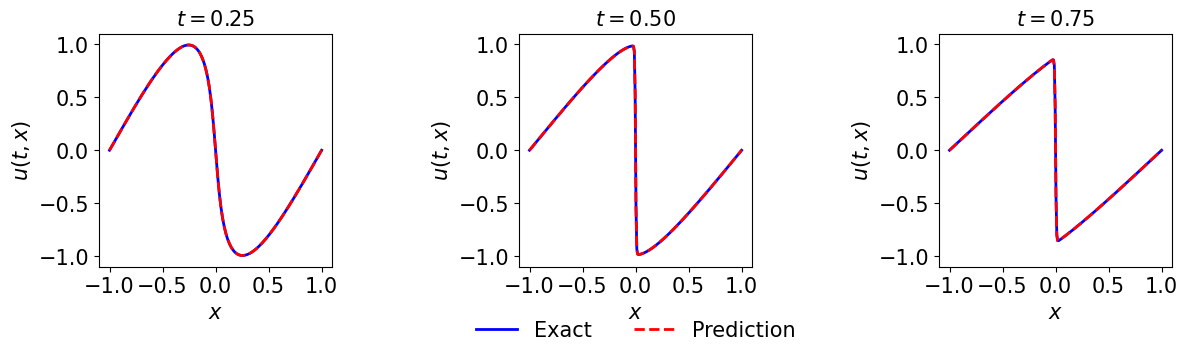

In [10]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

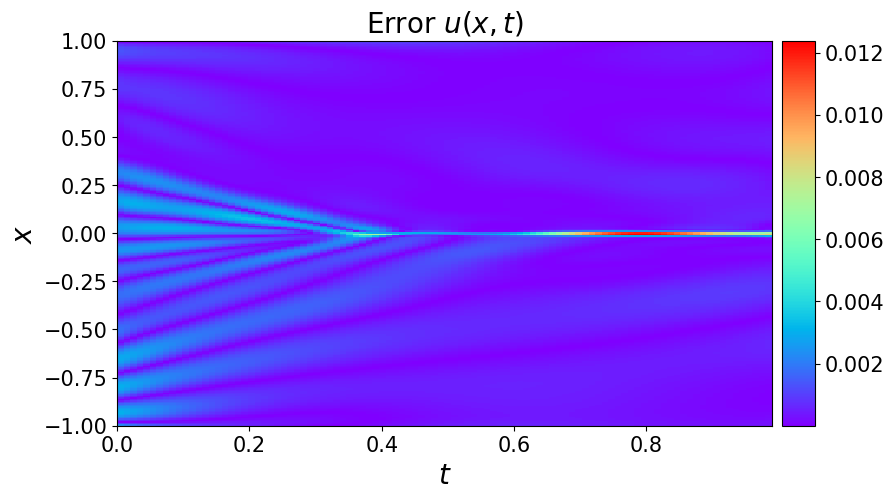

In [11]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)
""" The aesthetic setting has changed. """


xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# boundary conditions x = lb
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# boundary conditions, x = ub
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx2, xx3]) 


####### Row 0: u(t,x) ##################    
X_u_train_ = X_u_train

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

h = ax.imshow(Error.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
            #   vmin = 0,
            #   vmax = 0.5770284271569969)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train_[:,1], 
#     X_u_train_[:,0], 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# )


ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('Error $u(x,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

In [12]:
print('Error u: %e' % (error_u))
print('Residual: %e' % (f_pred**2).mean())

Error u: 1.504027e-03
Residual: 1.284123e-05


## 